In [1]:
import brainpy.math as bm
import numpy as np
from models import PC_cell_topdown_asym
from scipy.interpolate import interp1d

#for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.ndimage import gaussian_filter


%matplotlib inline  
%load_ext autoreload 
%autoreload 2

In [2]:
def get_tuningMap(activity, positions, cellindex_x, cellindex_y, shift, 
                 filter=False, firing_rate_thres=0.05, samples_per_sec=10, dim=40):
    '''
    Get the tuning map of a cell
    Input:
        activity: the activity of the network across time
        positions: the position of the animal
        cellindex_x: the x index of the cell
        cellindex_y: the y index of the cell
        shift: the shift of the activity; Positive values shift the activity to the right, negative values to the left
        firing_rate_thres: the threshold of the firing rate
    '''
    
    activity_4_cell_i = activity[:, cellindex_x, cellindex_y]
    
    activity_4_cell_i = np.roll(activity_4_cell_i, shift) #positive shift means shift to the right!!
    
    #position in bins
    position_x = positions[:,0]; position_x = (position_x*dim).astype(int)
    position_y = positions[:,1]; position_y = (position_y*dim).astype(int)
    
    #Calculate the summarized  activity and the occupancy time in each position bin 
    n_bins_x = dim; n_bins_y = dim
    Time_In_Position = np.zeros((n_bins_x, n_bins_y))
    FR_In_Position = np.zeros((n_bins_x, n_bins_y))

    diffTimeStamps = np.asarray([1/samples_per_sec]*len(positions))
    np.add.at(Time_In_Position, (position_x, position_y), diffTimeStamps)
    np.add.at(FR_In_Position, (position_x, position_y), activity_4_cell_i)
    
    map = np.divide(FR_In_Position, Time_In_Position, out=np.zeros_like(FR_In_Position), where=Time_In_Position!=0)
    
    if filter is True:
        #Gaussian smoothing the map
        map = gaussian_filter(map, sigma=2)
    
    # #get the quantity of the rate map
    # map_criteria = {}
    # #first, firing area
    # map_criteria['firing_area'] = get_firing_area(map, firing_rate_thres)
    # #second, patchiness
    # map_criteria['patchiness'] = get_patchiness(map)
    # #third, spatial coherence
    # map_criteria['spatial_coherence'] = get_spatial_cohenrence(map)
    # #fourth, spatial information content
    # map_criteria['spatial_information_content'] = spatial_information_content(map, FR_In_Position, Time_In_Position)
    
    # return map, map_criteria
    
    return map

def simulate_honeycomb_movement(total_time=1, 
                                dt=0.01, 
                                move_prob=0.95, 
                                drift_factor=0.0, 
                                velocity=0.5, 
                                rotation_speed=np.pi / 50, 
                                direction='clockwise'):
    """
    Simulates rat-like movement where a point (B) moves with random walks and rotations around a base point (A),
    ensuring time steps are correctly accounted for during rotation and then upsampled to 1ms resolution.

    Parameters:
        total_time (float): Total simulation time in seconds.
        dt (float): Time step size in seconds.
        move_prob (float): Probability of movement instead of rotation.
        drift_factor (float): Controls movement direction drift (0 = fully random, 1 = smooth drift).
        velocity (float): Speed of movement in m/s.
        rotation_speed (float): Angular speed per time step during rotation (radians per step).

    Returns:
        B_trajectory_upsampled (numpy array): Nx2 array of (x, y) positions of B (upsampled to 1ms).
        head_directions_upsampled (numpy array): Head direction angles (in radians, wrapped between -π and π).
        speeds_upsampled (numpy array): Speed of B at each time step (in m/s, upsampled).
        rotation_phases_upsampled (numpy array): Boolean array marking rotation phases (upsampled).
        time_upsampled (numpy array): Time points corresponding to the upsampled trajectory (seconds).
    """
    # Environment parameters
    env_size = 1.0  # 1m x 1m environment
    stick_length = 0.1  # 0.1m stick (hip-to-head distance)
    time_steps = int(total_time / dt)  # Convert total time to number of steps

    # Initialize positions at the center of the environment
    pos_A = np.array([env_size / 2 + 0.5, env_size / 2 + 0.5])
    angle = 0  # Initial head direction
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

    # Initialize movement direction
    move_angle = np.random.uniform(-np.pi, np.pi)

    # Store B trajectory, head directions, and movement markers
    B_trajectory = []
    head_directions = []
    rotation_phases = []
    time_list = []

    step_count = 0  # Track total simulation steps
    current_time = 0  # Initialize simulation time

    while step_count < time_steps:
        if np.random.rand() < move_prob:
            # Move in a direction with drift control
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt  # Distance moved per time step

            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])

            # Keep within bounds
            new_pos_A = np.clip(new_pos_A, 0, env_size)

            # Update A and B positions
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)  # Movement phase
            time_list.append(current_time)

            step_count += 1  # Increment time step
            current_time += dt

        else:
            # Rotate B around A
            rotation_duration = int(np.random.uniform(0.6, 1.0) / dt)  # Random rotation duration (0.6 to 1.0 sec)
            for _ in range(min(rotation_duration, time_steps - step_count)):  # Ensure we don't exceed time_steps
                if direction == 'clockwise':
                    angle -= rotation_speed
                elif direction == 'counter_clockwise':
                    angle += rotation_speed  # Small angle increment per time step
                else:
                    raise ValueError("Invalid rotation direction. Use 'clockwise' or 'counter_clockwise'.")
                angle = (angle + np.pi) % (2 * np.pi) - np.pi  # Wrap between -π and π
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)  # Rotation phase
                time_list.append(current_time)

                step_count += 1  # Increment time step
                current_time += dt
                if step_count >= time_steps:
                    break  # Stop when time limit is reached

    # Convert lists to numpy arrays for processing
    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    time_original = np.array(time_list)

    # Compute speed using finite differences
    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))  # Speed in m/s, prepend 0 for length consistency

    # Upsample to 1ms resolution
    dt_new = 0.001  # 1ms
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    # Interpolation functions for upsampling
    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")  # Avoid last speed point

    # Apply interpolation
    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)  # Speed is one step shorter

    # Handle head direction wrapping (-π to π)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    # Upsample rotation phases (binary nearest interpolation)
    interp_rotation = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation(time_upsampled).astype(bool)

    return B_trajectory_upsampled, head_directions_upsampled, speeds_upsampled, rotation_phases_upsampled, time_upsampled


## Section 2 simulate clockwise rotation

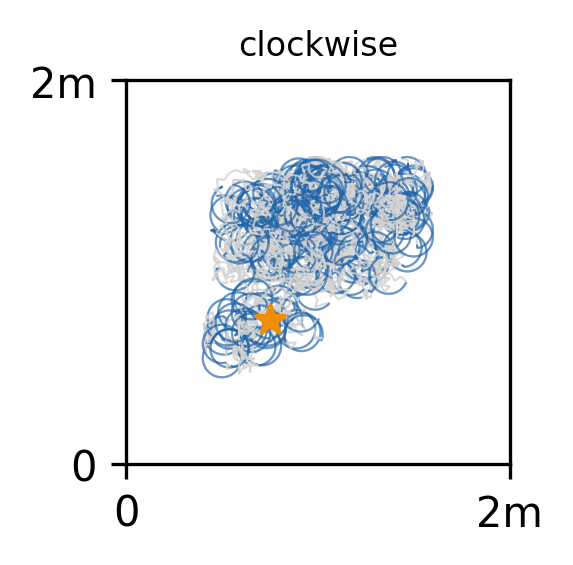

In [3]:
# Seed for reproducibility
# np.random.seed(111)
direction = 'clockwise'
# direction = 'counter_clockwise'
# Run the function to generate movement data
Position, head_directions, Speed, rotation_phases, time_upsampled = simulate_honeycomb_movement(total_time=200, dt=0.01, move_prob=0.95, velocity=4,
                                                                                                direction=direction)

Speed = Speed/1000
Position = Position + 0.5 

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=300)


# 1. XY Trajectory Plot (Upsampled)
segments = np.array([[Position[i], Position[i + 1]] for i in range(len(Position) - 1)])
if direction == 'clockwise':
    colors = ['#2167AC' if rotation_phases[i] else 'lightgrey' for i in range(len(Position) - 1)] #28A25F
elif direction == 'counter_clockwise':
    colors = ['#28A25F' if rotation_phases[i] else 'lightgrey' for i in range(len(Position) - 1)]
else:   
    raise ValueError("Invalid rotation direction. Use 'clockwise' or 'counter_clockwise'.")
lc = LineCollection(segments, colors=colors, linewidths=0.5, alpha=1)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(0,2)
ax.set_xticks([0, 2])
ax.set_xticklabels(['0', '2m'])
ax.set_ylim(0,2)
ax.set_yticks([0, 2])
ax.set_yticklabels(['0', '2m'])


#add goal location
goal_loc = (0.75, 0.75)
ax.scatter(goal_loc[0], goal_loc[1], color='#F18D00', marker='*', s=50, zorder=10)


ax.set_title(direction, fontsize=8)

plt.tight_layout()

plt.savefig('./figures/trajectory_' + direction + '.pdf', dpi=300)


In [4]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

#hyperparameters
m0 = 12 #adaptation strength #10
z_min = 0; z_max = 2 #the size of the environment, have to be the same as the environment size
duration = int(len(Position)) #simulation duration of the trajectory
alpha_pc = 0.5 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis
goal_loc = [0.5, 0.5]

topdown = False

PC_net = PC_cell_topdown_asym(num=num, 
                        tau=10, 
                        tauv=150, 
                        m0=m0, 
                        k=1, 
                        a=0.20, 
                        A=10.0, 
                        J0=8.0, 
                        goal_a=0.6,
                        goal_b=1.0,
                        goal_A=8.0,
                        asym_J0 = 0.1,
                        asym_a = 0.5,
                        z_min=z_min, 
                        z_max=z_max,    
                        conn_noise=0.0, 
                        rec_noise=0.0,     
                        goal_loc=goal_loc,
                        topdown=topdown,
                        asymmetry=False,
                        tdstyle='Gaussian')

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator_BU = 0.5+theta_mod_strength*bm.cos(theta_phase*2*bm.pi) #0.5
    Topdown_mod = 1.2 #0.6 #1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi + bm.pi) #1.2
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator_BU, Topdown_mod)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumcenter = PC_net.center
    return pc_activity, pc_bumcenter, theta_phase, ThetaModulator_BU

time_steps = np.arange(len(Position))
print('Running simulation...')

@bm.jit
def run(time, pos, speed):
    return bm.for_loop(runNet, (time, pos, speed))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Position), num, num))
pc_bumpcenter = np.empty((len(Position), 2))
theta_phase = np.empty(len(Position))
theta_rhythm = np.empty(len(Position))

for i in range(0, len(Position), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Position)*100))
    pc_activity_i, pc_bumpcenter_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], Position[i:i+simulate_time], Speed[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

2025-03-27 23:32:05.791978: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%
Simulation progress: 25%
Simulation progress: 50%
Simulation progress: 75%


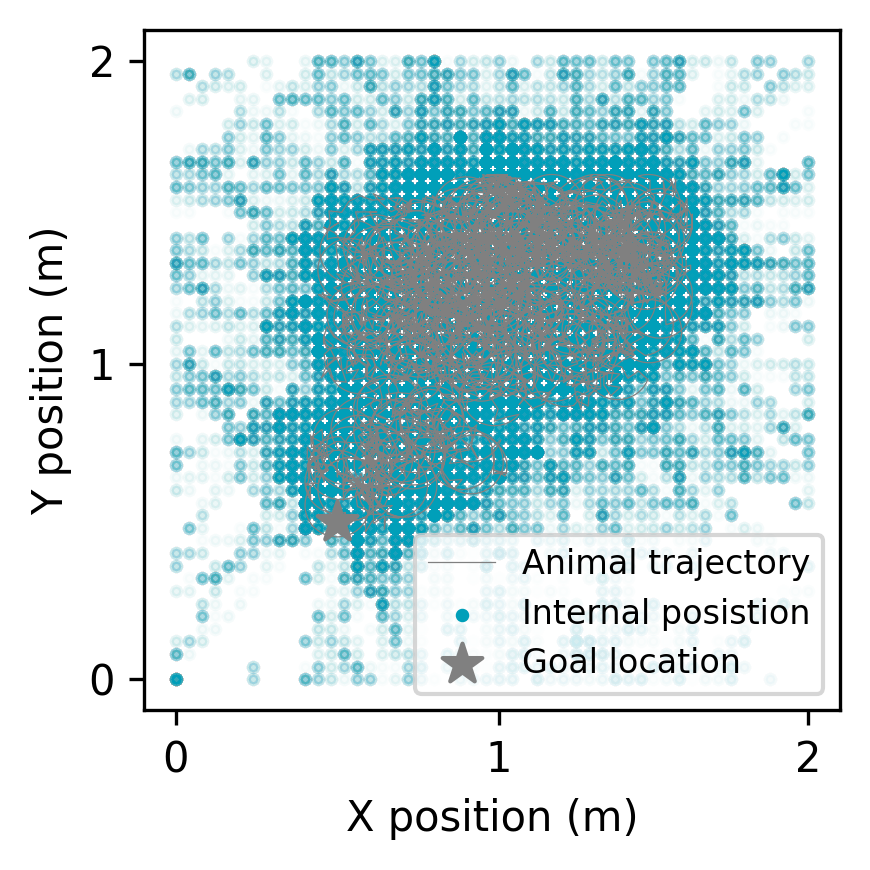

In [5]:
fig, ax  = plt.subplots(1, 1, figsize=(3,3), dpi=300)
# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Position[:, 0]/z_max * num, Position[:, 1]/z_max * num, color='grey', linewidth=0.3, label='Animal trajectory')
ax.scatter(pc_bumpcenter[:, 0], pc_bumpcenter[:, 1], color='#009FB9', s=5, alpha=0.02)
ax.scatter(pc_bumpcenter[0, 0], pc_bumpcenter[0, 1], color='#009FB9', s=5, label='Internal posistion', alpha=1.0) #only for label legend use

if topdown:
    ax.scatter(goal_loc[0]/z_max*num, goal_loc[1]/z_max*num, color='#F28D00', marker='*', s=100, label='Goal location')
else:
    ax.scatter(goal_loc[0]/z_max*num, goal_loc[1]/z_max*num, color='grey', marker='*', s=100, label='Goal location')

ax.set_xticks([0, num//2, num-1])
ax.set_xticklabels([0, 1, 2])
ax.set_yticks([0, num//2, num-1])
ax.set_yticklabels([0, 1, 2])
ax.legend(fontsize=8)
ax.set_xlabel('X position (m)', fontsize=10)
ax.set_ylabel('Y position (m)', fontsize=10)

plt.tight_layout()

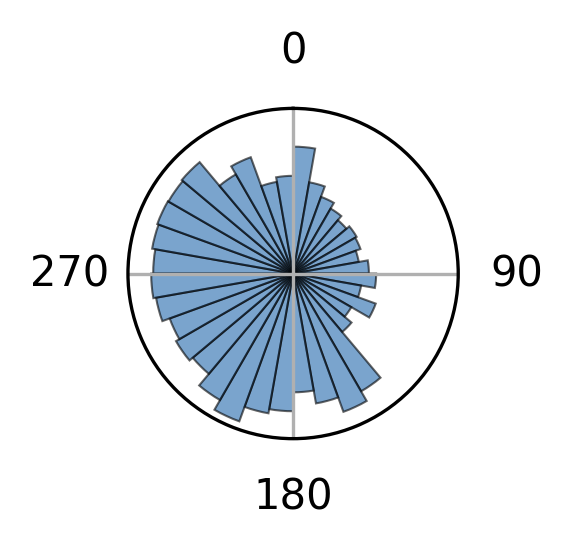

In [6]:
# Compute relative angles in range [-π, π]
relative_angle = np.zeros(len(head_directions))

for i in range(len(head_directions)):
    # Unit vector of head direction
    vec1 = np.array([np.cos(head_directions[i]), np.sin(head_directions[i])])
    
    # Vector from current position to goal
    vec2 = goal_loc - Position[i]  # (goal - current position)
    vec2 = vec2 / np.linalg.norm(vec2)  # Normalize vec2
    
    # Compute the signed angle using atan2
    relative_angle[i] = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec1[1], vec1[0])
    
    # Wrap angle to range [-π, π]
    relative_angle[i] = (relative_angle[i] + np.pi) % (2 * np.pi) - np.pi

# Define the range of cell indices
start_idx = 10
end_idx = 20  # inclusive

# Define bins for relative angles from -π to π
num_bins = 36
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

# Initialize accumulator for summed activity across all selected cells
total_binned_activity = np.zeros(num_bins)
num_cells = 0

# Loop through the specified submatrix of cells
for i in range(start_idx, end_idx + 1):
    for j in range(start_idx, end_idx + 1):
        pc_activity_ij = pc_activity[:, i, j]
        binned_activity = np.zeros(num_bins)
        bin_indices = np.digitize(relative_angle, angle_bins) - 1

        for k in range(len(relative_angle)):
            if 0 <= bin_indices[k] < num_bins:
                binned_activity[bin_indices[k]] += pc_activity_ij[k]

        total_binned_activity += binned_activity
        num_cells += 1

# Compute the average binned activity
average_binned_activity = total_binned_activity / num_cells

# Convert bin centers to polar coordinates
theta = np.append(bin_centers, bin_centers[0])
average_binned_activity = np.append(average_binned_activity, average_binned_activity[0])

# # Create polar plot
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.plot(theta, average_binned_activity, color='red', linewidth=2)
# ax.fill(theta, average_binned_activity, color='red', alpha=0.3)

# # ax.set_title("Average Place Cell Activity (Cells [10,10] to [30,30])")

# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)

# plt.show()

# Create polar plot with bars instead of line
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(2, 2), dpi=300)

# Bar width based on bin size
bar_width = 2 * np.pi / num_bins

if direction == 'clockwise':
    color_ = '#2167AC'
elif direction == 'counter_clockwise':
    color_ = '#28A25F'
else:
    raise ValueError("Invalid rotation direction. Use 'clockwise' or 'counter_clockwise'.")

# Use only the first 36 values (drop the wrapped one)
bars = ax.bar(
    bin_centers,
    average_binned_activity[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color=color_, #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

# Polar aesthetics
ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
# ax.set_title('Average Place Cell Activity by Angle', va='bottom')

#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])

#remove y ticks
ax.set_yticks([])

# plt.show()

plt.tight_layout()

plt.savefig('./figures/anticipatory_' + direction + '.pdf', dpi=300)


